In [1]:
import cv2
import cv2 as cv
import numpy as np
import os
import pandas as pd
import pywt
import random
import re
import sporco
import torch
from scipy import linalg as la
from torchvision.models.vgg import vgg19
from tqdm import tqdm
import matplotlib.pyplot as plt
import time

import matplotlib.pyplot as plt
from netCDF4 import Dataset

In [2]:


def check_string_or_np_array(value) -> np.ndarray:
    """
    Check if the input value is a string (file path) or a NumPy array.
    
    Parameters:
        value (str or np.ndarray): The input value.
        
    Returns:
        np.ndarray: If the input value is a string, the function returns the image read from the file.
                   If the input value is a NumPy array, the function returns the input value itself.
    """
    if isinstance(value, str):
        # Read the image from the file
        out = cv2.imread(value)
    elif isinstance(value, np.ndarray):
        # If it's already a NumPy array, no need to modify it
        out = value
    else:
        # If it's neither a string nor a NumPy array, return it as is
        out = value
    
    return out





In [3]:



def signaltonoise(a, axis, ddof):
    """
    Compute the signal-to-noise ratio of an array.

    Args:
        a (ndarray): Input array.
        axis (int or None): Axis along which to compute the mean and standard deviation.
        ddof (int): Delta degrees of freedom.

    Returns:
        ndarray: Signal-to-noise ratio.

    """
    a = np.asanyarray(a)
    m = a.mean(axis)
    sd = a.std(axis=axis, ddof=ddof)
    return np.where(sd == 0, 0, m / sd)


def lowpass(s, lda, npad):
    """
    Perform low pass filtering using Tikhonov filter.

    Args:
        s (ndarray): Input array.
        lda (float): Regularization parameter.
        npad (int): Number of pixels to pad.

    Returns:
        ndarray: Filtered array.

    """
    # return tikhonov_filter(s, lda, npad)
    return sporco.signal.tikhonov_filter(s, lda, npad)


def get_activation(model, layer_numbers, input_image):
    """
    Get the activations of specified layers in a given model.

    Args:
        model: Pretrained model.
        layer_numbers (list): List of layer numbers to retrieve activations from.
        input_image (Tensor): Input image.

    Returns:
        list: List of activation arrays.

    """
    outs = []
    out = input_image
    for i in range(max(layer_numbers) + 1):
        with torch.no_grad():  # Reduces memory usage and speeds up calculations
            out = model.features[i](out)
        if i in layer_numbers:
            outs.append(np.rollaxis(out.detach().cpu().numpy()[0], 0, 3))
    return outs


def c3(s):
    """
    Convert a 2D or 3D image to a 3D array and rotate.

    Args:
        s (ndarray): Input image.

    Returns:
        ndarray: Rotated 3D array.

    """
    if s.ndim == 2:
        s3 = np.dstack([s, s, s])
    else:
        s3 = s
    return np.rollaxis(s3, 2, 0)[None, :, :, :]


def l1_features(out):
    """
    Compute L1 norm of the given array and return a matrix with zero edges.

    Args:
        out (ndarray): Input array.

    Returns:
        ndarray: L1 norm array with zero edges.

    """
    h, w, d = out.shape
    a_temp = np.zeros((h + 2, w + 2))  # All edges of the Matrix have been zero

    l1_norm = np.sum(np.abs(out), axis=2)
    a_temp[1:h + 1, 1:w + 1] = l1_norm
    return a_temp



def Fusion_PCA(rgb, sar):
    """
    Performs image fusion using PCA (Principal Component Analysis) algorithm.

    Args:
        rgb (numpy.ndarray): RGB image dataset (matrix) to be fused.
        sar (numpy.ndarray): SAR image dataset (matrix) to be fused.

    Returns:
        numpy.ndarray: Fused image dataset (matrix).
    """
    # Converting Image data to numpy Array to be able to do necessary calculation
    a = np.array(rgb)
    b = np.array(sar)
    # getting Image dimensions
    temp1 = a.shape
    temp2 = b.shape
    # Starting PCA algorithm
    # creating matrix with both Images
    vector1 = np.reshape(a, temp1[0] * temp1[1], order='F')
    vector2 = np.reshape(b, temp2[0] * temp2[1], order='F')
    # Convolution of created matrix
    c = np.cov(vector1, vector2)
    # getting Eigenvalue and Eigenvector of this matrix
    d, v = la.eig(c)
    sum1 = np.sum(v, axis=0)
    # Calculating PCA
    if d[0] >= d[1]:
        pca = np.divide(v[:, 0], sum1[0])
    else:
        pca = np.divide(v[:, 1], sum1[1])
    # Creating fused image
    result = (pca[0] * rgb) + (pca[1] * sar)
    return result


def Fusion_DWT_db2(rgb, sar):
    """
    Performs image fusion using Discrete Wavelet Transform (DWT) with Daubechies filter (db2).

    Args:
        rgb (numpy.ndarray): RGB image dataset (matrix) to be fused.
        sar (numpy.ndarray): SAR image dataset (matrix) to be fused.

    Returns:
        numpy.ndarray: Fused image dataset (matrix).
    """
    # decomposing each image using Discrete Wavelet Transform (DWT) with Daubechies filter (db2)
    coefficients_1 = pywt.wavedec2(rgb, 'db2', level=2)
    coefficients_2 = pywt.wavedec2(sar, 'db2', level=2)
    # creating variables to be used
    coefficients_h = list(coefficients_1)
    # fusing the decomposed image data
    coefficients_h[0] = (coefficients_1[0] + coefficients_2[0]) * 0.5
    # creating variables to be used
    temp1 = list(coefficients_1[1])
    temp2 = list(coefficients_2[1])
    temp3 = list(coefficients_h[1])
    # fusing the decomposed image data
    temp3[0] = (temp1[0] + temp2[0]) * 0.5
    temp3[1] = (temp1[1] + temp2[1]) * 0.5
    temp3[2] = (temp1[2] + temp2[2]) * 0.5
    coefficients_h[1] = tuple(temp3)
    # Creating fused image by reconstructing the fused decomposed image
    result = pywt.waverec2(coefficients_h, 'db2')
    return result



def fusion_strategy(feat_a, feat_b, source_a, source_b, img, unit):
    """
    Weighted-averaging method for fusion of SAR and RGB images.
    Args:
        feat_a: Feature map of image A.
        feat_b: Feature map of image B.
        source_a: Source image A.
        source_b: Source image B.
        img: Image to be fused.
        unit: Unit size for fusion.

    Returns:
        Fused image.
    """
    m, n = feat_a.shape
    m1, n1 = source_a.shape[:2]
    weight_ave_temp1 = np.zeros((m1, n1))
    weight_ave_temp2 = np.zeros((m1, n1))
    weight_ave_temp3 = np.zeros((m1, n1))

    for i in range(1, m):
        for j in range(1, n):
            a1 = feat_a[i - 1:i + 1, j - 1:j + 1].sum() / 9
            a2 = feat_b[i - 1:i + 1, j - 1:j + 1].sum() / 9
            a3 = img[i - 1:i + 1, j - 1:j + 1].sum() / 9

            weight_ave_temp1[(i - 2) * unit + 1:(i - 1) * unit + 1, (j - 2) * unit + 1:(j - 1) * unit + 1] = a1 / (
                a1 + a2 + a3)
            weight_ave_temp2[(i - 2) * unit + 1:(i - 1) * unit + 1, (j - 2) * unit + 1:(j - 1) * unit + 1] = a2 / (
                a1 + a2 + a3)
            weight_ave_temp3[(i - 2) * unit + 1:(i - 1) * unit + 1, (j - 2) * unit + 1:(j - 1) * unit + 1] = a3 / (
                a1 + a2 + a3)

    if source_a.ndim == 3:
        weight_ave_temp1 = weight_ave_temp1[:, :, None]
    source_a_fuse = source_a * weight_ave_temp1
    if source_b.ndim == 3:
        weight_ave_temp2 = weight_ave_temp2[:, :, None]
    source_b_fuse = source_b * weight_ave_temp2
    if img.ndim == 3:
        weight_ave_temp3 = weight_ave_temp3[:, :, None]
    source_img_fuse = img * weight_ave_temp3

    if source_a.ndim == 3 or source_b.ndim == 3 or img.ndim == 3:
        gen = np.atleast_3d(source_a_fuse) + np.atleast_3d(source_b_fuse) + np.atleast_3d(source_img_fuse)
    else:
        gen = source_a_fuse + source_b_fuse + source_img_fuse

    return gen


def fusion_strategy2(feat_a, feat_b, source_a, source_b, img1, img2, unit):
    """
    Fusion strategy 2 for fusion of SAR and RGB images.
    Args:
        feat_a: Feature map of image A.
        feat_b: Feature map of image B.
        source_a: Source image A.
        source_b: Source image B.
        img1: Image 1 to be fused.
        img2: Image 2 to be fused.
        unit: Unit size for fusion.

    Returns:
        Fused image.
    """
    m, n = feat_a.shape
    m1, n1 = source_a.shape[:2]
    weight_ave_temp1 = np.zeros((m1, n1))
    weight_ave_temp2 = np.zeros((m1, n1))
    weight_ave_temp3 = np.zeros((m1, n1))
    weight_ave_temp4 = np.zeros((m1, n1))

    for i in range(1, m):
        for j in range(1, n):
            a1 = feat_a[i - 1:i + 1, j - 1:j + 1].sum() / 9
            a2 = feat_b[i - 1:i + 1, j - 1:j + 1].sum() / 9
            a3 = img1[i - 1:i + 1, j - 1:j + 1].sum() / 9
            a4 = img2[i - 1:i + 1, j - 1:j + 1].sum() / 9

            weight_ave_temp1[(i - 2) * unit + 1:(i - 1) * unit + 1, (j - 2) * unit + 1:(j - 1) * unit + 1] = a1 / (
                a1 + a2 + a3 + a4)
            weight_ave_temp2[(i - 2) * unit + 1:(i - 1) * unit + 1, (j - 2) * unit + 1:(j - 1) * unit + 1] = a2 / (
                a1 + a2 + a3 + a4)
            weight_ave_temp3[(i - 2) * unit + 1:(i - 1) * unit + 1, (j - 2) * unit + 1:(j - 1) * unit + 1] = a3 / (
                a1 + a2 + a3 + a4)
            weight_ave_temp4[(i - 2) * unit + 1:(i - 1) * unit + 1, (j - 2) * unit + 1:(j - 1) * unit + 1] = a4 / (
                a1 + a2 + a3 + a4)

    if source_a.ndim == 3:
        weight_ave_temp1 = weight_ave_temp1[:, :, None]
    source_a_fuse = source_a * weight_ave_temp1
    if source_b.ndim == 3:
        weight_ave_temp2 = weight_ave_temp2[:, :, None]
    source_b_fuse = source_b * weight_ave_temp2
    if img1.ndim == 3:
        weight_ave_temp3 = weight_ave_temp3[:, :, None]
    source_img_fuse = img1 * weight_ave_temp3
    if img2.ndim == 3:
        weight_ave_temp4 = weight_ave_temp4[:, :, None]
    source_img2_fuse = img2 * weight_ave_temp4

    if source_a.ndim == 3 or source_b.ndim == 3 or img1.ndim == 3 or img2.ndim == 3:
        gen = np.atleast_3d(source_a_fuse) + np.atleast_3d(source_b_fuse) + np.atleast_3d(
            source_img_fuse) + np.atleast_3d(source_img2_fuse)
    else:
        gen = source_a_fuse + source_b_fuse + source_img_fuse + source_img2_fuse

    return gen


def fuse(rgb, sar, model=None):
    """
    Fuse SAR and RGB images using a fusion strategy.
    Args:
        rgb: RGB image.
        sar: SAR image.
        model: Pre-trained VGG19 model for feature extraction.

    Returns:
        Fused image.
    """
    
    rgb = check_string_or_np_array(rgb)
    sar = check_string_or_np_array(sar)
    
    if len((sar).shape) != 2:
        sar = cv.cvtColor(sar, cv.COLOR_BGR2GRAY)
    if len((rgb).shape) != 2:
        rgb = cv.cvtColor(rgb, cv.COLOR_BGR2GRAY)
    
    npad = 16
    lda = 5
    rgb_low, rgb_high = lowpass(rgb.astype(np.float32) / 255, lda, npad)
    sar_low, sar_high = lowpass(sar.astype(np.float32) / 255, lda, npad)

    img = Fusion_DWT_db2(rgb.astype(np.float32) / 255, sar_high)
    img1 = Fusion_PCA(sar.astype(np.float32) / 255, sar_high)
    img2 = Fusion_PCA(rgb_high, rgb.astype(np.float32) / 255)
    snr = np.max(signaltonoise(img, axis=0, ddof=0))

    if model is None:
        model = vgg19(True)
    model.cuda().eval()
    relus = [2, 7, 12, 21]
    unit_relus = [1, 2, 4, 8]

    rgb_in = torch.from_numpy(c3(rgb_high)).cuda()
    sar_in = torch.from_numpy(c3(sar_high)).cuda()

    relus_rgb = get_activation(model, relus, rgb_in)
    relus_sar = get_activation(model, relus, sar_in)

    rgb_feats = [l1_features(out) for out in relus_rgb]
    sar_feats = [l1_features(out) for out in relus_sar]

    saliencies = []
    saliency_max = None

    if 10 < snr < 19:
        for idx in range(len(relus)):
            saliency_current = fusion_strategy(rgb_feats[idx], sar_feats[idx],
                                               rgb_high, sar_high, img, unit_relus[idx])
            saliencies.append(saliency_current)

            if saliency_max is None:
                saliency_max = saliency_current
            else:
                saliency_max = np.maximum(saliency_max, saliency_current)

    else:
        for idx in range(len(relus)):
            saliency_current = fusion_strategy2(rgb_feats[idx], sar_feats[idx],
                                                rgb_high, sar_high, img1, img2, unit_relus[idx])
            saliencies.append(saliency_current)

            if saliency_max is None:
                saliency_max = saliency_current
            else:
                saliency_max = np.maximum(saliency_max, saliency_current)

    if rgb_low.ndim == 3 or sar_low.ndim == 3:
        low_fused = np.atleast_3d(rgb_low) + np.atleast_3d(sar_low)
    else:
        low_fused = rgb_low + sar_low
    low_fused = low_fused / 2
    high_fused = saliency_max

    return low_fused + high_fused




def show_images(rgb_image, sar_image, fused_image):
    """
    Display RGB, SAR, and fused images using matplotlib.pyplot.

    Arguments:
    rgb_image -- RGB image as a numpy array or a string representing the image file path
    sar_image -- SAR image as a numpy array or a string representing the image file path
    fused_image -- Fused image as a numpy array or a string representing the image file path
    """

    # Check if the input images are numpy arrays or file paths
    if isinstance(rgb_image, str):
        rgb_image = cv2.imread(rgb_image)  # Read RGB image using cv2 if it is a file path
    if isinstance(sar_image, str):
        sar_image = cv2.imread(sar_image, cv2.IMREAD_GRAYSCALE)  # Read SAR image using cv2 if it is a file path
    if isinstance(fused_image, str):
        fused_image = cv2.imread(fused_image)  # Read fused image using cv2 if it is a file path

    # Create a figure and set up subplots
    fig, axes = plt.subplots(1, 3, figsize=(12, 4))

    # Plot RGB image
    axes[0].imshow(rgb_image)
    axes[0].set_title('RGB Image')
    axes[0].axis('off')

    # Plot SAR image
    axes[1].imshow(sar_image)
    axes[1].set_title('SAR Image')
    axes[1].axis('off')

    # Plot fused image
    axes[2].imshow(fused_image, cmap='gray')
    axes[2].set_title('Fused Image')
    axes[2].axis('off')
    
    # Adjust spacing between subplots
    plt.tight_layout()

    # Show the figure
    plt.show()


In [4]:

# Function to save the data from a .nc file as an image
def save_nc_as_image(file_path, output_image_path):
    # Open the .nc file and read the SAR data
    ds = Dataset(file_path)
    sar_data = ds.variables['data'][:]

    # Get the aspect ratio based on the original image dimensions
    height, width = sar_data.shape[1], sar_data.shape[2]
    aspect_ratio = height / width

    # Create a figure with the specified aspect ratio
    fig = plt.figure(figsize=(1, aspect_ratio))

    # Display the SAR data with the original colormap
    plt.imshow(sar_data[0], origin='lower', aspect='auto')

    # Remove axis ticks and labels
    plt.axis('off')

    # Save the figure as an image file with the specified aspect ratio
    plt.savefig(output_image_path, bbox_inches='tight', pad_inches=0, dpi=300)

    # Close the figure to release resources
    plt.close(fig)


    
def convert_nc_to_pngList(file_list):
    # Filter the files that end with '.nc'
    nc_files = [file for file in file_list if file.endswith('.nc')]

    # Get the basenames and replace the '.nc' extension with '.png'
    png_files = [os.path.splitext(os.path.basename(file))[0] + '.png' for file in nc_files]

    return png_files

import os

def convert_nc_to_png(file_path):
    # Check if the file ends with '.nc'
    if file_path.endswith('.nc'):
        # Get the basename and replace the '.nc' extension with '.png'
        png_file = os.path.splitext(os.path.basename(file_path))[0] + '.png'
        return png_file
    else:
        return None  # Return None if the file does not end with '.nc'





In [5]:
dataDir = os.path.join('..','WindBlad_result','datac')
os.startfile(dataDir)

In [6]:
# ouput_folder = "data2"
# root = "./data"
# a = os.path.join(root,ouput_folder)
data_folder = dataDir
fused_dir = data_folder+"/Fused"
# fused_dir = os.path.join(data_folder,"Fused")

os.makedirs(data_folder, exist_ok=True)
os.makedirs(fused_dir, exist_ok=True)

# paths =  Path(sys.path[0]+'/data'+"/"+ouput_folder)
# paths = os.path.join(sys.path[0], 'data', ouput_folder)
# paths

In [7]:
import os
import sys

def add_path_to_sys(path):
    module_path = os.path.abspath(path)
    if module_path not in sys.path:
        sys.path.append(module_path)

usePath = os.path.join(r'c:', os.sep,'Users','scrwh','Documents','PythonScripts')
add_path_to_sys(usePath)

import nbimporter
import import_ipynb

import ModelsListDiffFuntionsB
from ModelsListDiffFuntionsB import *

# List all the functions defined in the other notebook
print(dir(ModelsListDiffFuntionsB))

['AbstractRNNCell', 'Activation', 'ActivityRegularization', 'Adam', 'Add', 'AdditiveAttention', 'AlphaDropout', 'Attention', 'Average', 'AveragePooling1D', 'AveragePooling2D', 'AveragePooling3D', 'AvgPool1D', 'AvgPool2D', 'AvgPool3D', 'BatchNormalization', 'Bidirectional', 'CategoryEncoding', 'CenterCrop', 'Concatenate', 'ConfusionMatrixDisplay', 'Conv1D', 'Conv1DTranspose', 'Conv2D', 'Conv2DTranspose', 'Conv3D', 'Conv3DTranspose', 'ConvLSTM1D', 'ConvLSTM2D', 'ConvLSTM3D', 'Convolution1D', 'Convolution1DTranspose', 'Convolution2D', 'Convolution2DTranspose', 'Convolution3D', 'Convolution3DTranspose', 'Cropping1D', 'Cropping2D', 'Cropping3D', 'Dense', 'DenseFeatures', 'DepthwiseConv1D', 'DepthwiseConv2D', 'DetCurveDisplay', 'Discretization', 'DistanceMetric', 'Dot', 'Dropout', 'ELU', 'EarlyStopping', 'EinsumDense', 'Embedding', 'EvaluateTest', 'FileTree', 'Flatten', 'FolderTree', 'GPUtil', 'GRU', 'GRUCell', 'GaussianDropout', 'GaussianNoise', 'GlobalAveragePooling1D', 'GlobalAveragePooli

In [8]:
# Get the list of all files in directory tree at given path
dataDir = os.path.join('..','WindBlad_result')
listOfFiles = get_file_list(dataDir)
listOfFiles

['..\\WindBlad_result\\datac.zip',
 '..\\WindBlad_result\\File_Read_Data.py',
 '..\\WindBlad_result\\Blad_1\\Blad1.png',
 '..\\WindBlad_result\\Blad_1\\Blad1_DataFIle.nc',
 '..\\WindBlad_result\\Blad_1\\Blad1_fft.png',
 '..\\WindBlad_result\\Blad_1\\Blad1_Zoom.png',
 '..\\WindBlad_result\\Blad_1\\Blad1_Zoom_DataFIle.nc',
 '..\\WindBlad_result\\Blad_1\\Blad1_Zoom_fft.png',
 '..\\WindBlad_result\\Blad_1\\Blad_1_orignal_img.png',
 '..\\WindBlad_result\\Blad_2\\Blad2.png',
 '..\\WindBlad_result\\Blad_2\\Blad2_DataFile.nc',
 '..\\WindBlad_result\\Blad_2\\Blad2_fft.png',
 '..\\WindBlad_result\\Blad_2\\Blad2_Orignal.jpg',
 '..\\WindBlad_result\\Blad_2\\Blad2_Zoom.png',
 '..\\WindBlad_result\\Blad_2\\Blad2_Zoom_DataFIle.nc',
 '..\\WindBlad_result\\Blad_2\\Blad2_Zoom_fft.png',
 '..\\WindBlad_result\\Blad_3\\Blad3.png',
 '..\\WindBlad_result\\Blad_3\\Blad3_DataFile.nc',
 '..\\WindBlad_result\\Blad_3\\Blad3_fft.png',
 '..\\WindBlad_result\\Blad_3\\Blad3_Orignal.jpg',
 '..\\WindBlad_result\\Blad_3

In [74]:
# Filter the files that end with '.nc'
nc_files = [file for file in listOfFiles if file.endswith('.nc')]

# Get the basenames and replace the '.nc' extension with '.png'
png_files = [os.path.splitext(os.path.basename(file))[0] + '.png' for file in nc_files]

print(png_files)

['Blad1_DataFIle.png', 'Blad1_Zoom_DataFIle.png', 'Blad2_DataFile.png', 'Blad2_Zoom_DataFIle.png', 'Blad3_DataFile.png', 'Blad3_Zoom_DataFile.png', 'Blad1B_DataFIle.png', 'Blad2B_DataFile.png', 'Blad3B_DataFile.png', 'Blad1B_DataFIle.png', 'Blad2B_DataFile.png', 'Blad3B_DataFile.png']


In [9]:
directory_path = os.path.join('Output','Dataz')
os.makedirs(directory_path, exist_ok=True)

In [10]:
# Convert all the Sar data into an image
for file in listOfFiles:    
    if file.endswith('.nc'):
        save_nc_as_image(file, os.path.join(directory_path,convert_nc_to_png(file)))

In [68]:
# Get the list of all files in directory tree at given path
listOfFiles = get_file_list('Data')
listOfFiles

['Data\\Data1\\Blad1A_orignal_img.png',
 'Data\\Data1\\Blad1B_DataFIleb.png',
 'Data\\Data1\\Blad1C.png',
 'Data\\Data1\\Blad2A_Orignal.jpg',
 'Data\\Data1\\Blad2B_DataFileb.png',
 'Data\\Data1\\Blad2C.png',
 'Data\\Data1\\Blad3A_Orignal.jpg',
 'Data\\Data1\\Blad3B_DataFileb.png',
 'Data\\Data1\\Blad3C.png',
 'Data\\Datak\\Blad1A_orignal_img.png',
 'Data\\Datak\\Blad1B_DataFIle.nc',
 'Data\\Datak\\Blad1C.png',
 'Data\\Datak\\Blad1D_Zoom.png',
 'Data\\Datak\\Blad1E_fused.png',
 'Data\\Datak\\Blad2A_Orignal.jpg',
 'Data\\Datak\\Blad2B_DataFile.nc',
 'Data\\Datak\\Blad2C.png',
 'Data\\Datak\\Blad2D_Zoom.png',
 'Data\\Datak\\Blad2E_fused.jpg',
 'Data\\Datak\\Blad3A_Orignal.jpg',
 'Data\\Datak\\Blad3B_DataFile.nc',
 'Data\\Datak\\Blad3C.png',
 'Data\\Datak\\Blad3D_Zoom.png',
 'Data\\Datak\\Blad3E_fused.jpg']

In [69]:
S1 = [x for x in listOfFiles if re.match(r"^.*Blad\d+A.*\.(png|jpg)$", x)]
S2 = [x for x in listOfFiles if re.match(r"^.*Blad\d+B.*\.(png|jpg)$", x)]

S1.sort()
S2.sort()

print("S1", len(S1))
print("S2", len(S2))

print("S1 \n", S1)
print("S2 \n", S2)

# S1[:2]

S1 6
S2 3
S1 
 ['Data\\Data1\\Blad1A_orignal_img.png', 'Data\\Data1\\Blad2A_Orignal.jpg', 'Data\\Data1\\Blad3A_Orignal.jpg', 'Data\\Datak\\Blad1A_orignal_img.png', 'Data\\Datak\\Blad2A_Orignal.jpg', 'Data\\Datak\\Blad3A_Orignal.jpg']
S2 
 ['Data\\Data1\\Blad1B_DataFIleb.png', 'Data\\Data1\\Blad2B_DataFileb.png', 'Data\\Data1\\Blad3B_DataFileb.png']


In [37]:
datas = []
for i in range(len(S1)):
    name = S1[i].split(os.path.sep)[-1].replace('A_orignal_img','_fused').replace('A_Orignal','_fused')
    S = (name,S1[i],S2[i])
    datas.append(S)
    
print(datas)    

[('Blad1_fused.png', 'Data\\Blad1A_orignal_img.png', 'Data\\Blad1B_DataFIleb.png'), ('Blad2_fused.jpg', 'Data\\Blad2A_Orignal.jpg', 'Data\\Blad2B_DataFileb.png'), ('Blad3_fused.jpg', 'Data\\Blad3A_Orignal.jpg', 'Data\\Blad3B_DataFileb.png')]


In [38]:


# Check if a GPU is available
if tf.config.list_physical_devices('GPU'):
    print("GPU available, training on GPU...")
    device_name = tf.test.gpu_device_name()
else:
    print("GPU not available, training on CPU...")
    device_name = "/CPU:0"

GPU available, training on GPU...


  0%|          | 0/3 [00:00<?, ?it/s]

<class 'numpy.ndarray'>


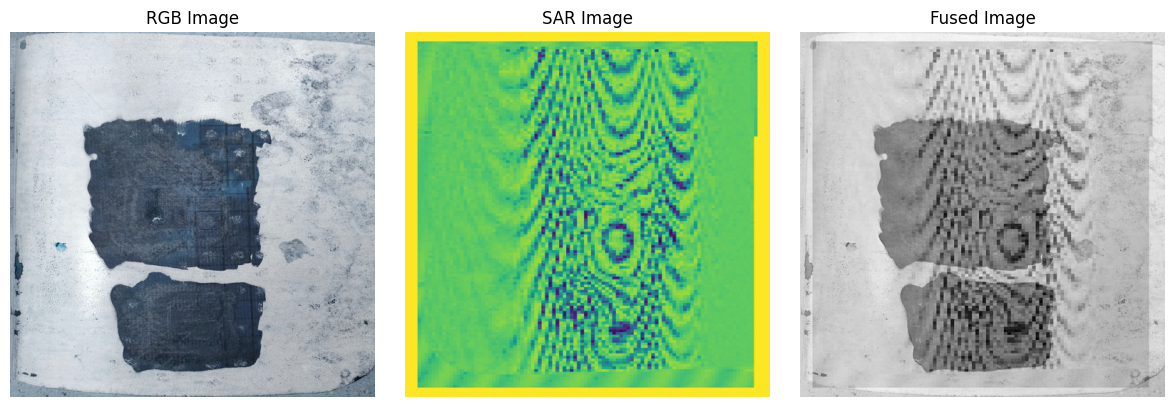

 33%|███▎      | 1/3 [00:06<00:12,  6.14s/it]

<class 'numpy.ndarray'>


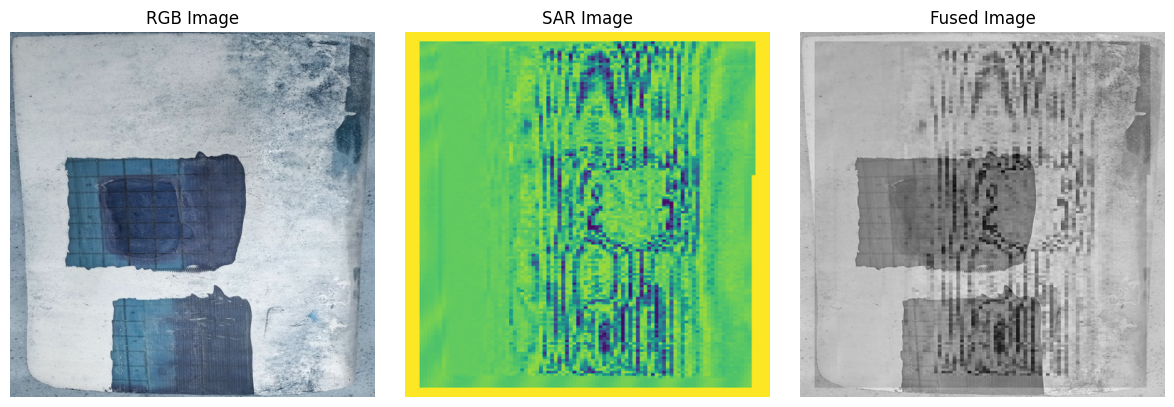

 67%|██████▋   | 2/3 [00:12<00:06,  6.41s/it]

<class 'numpy.ndarray'>


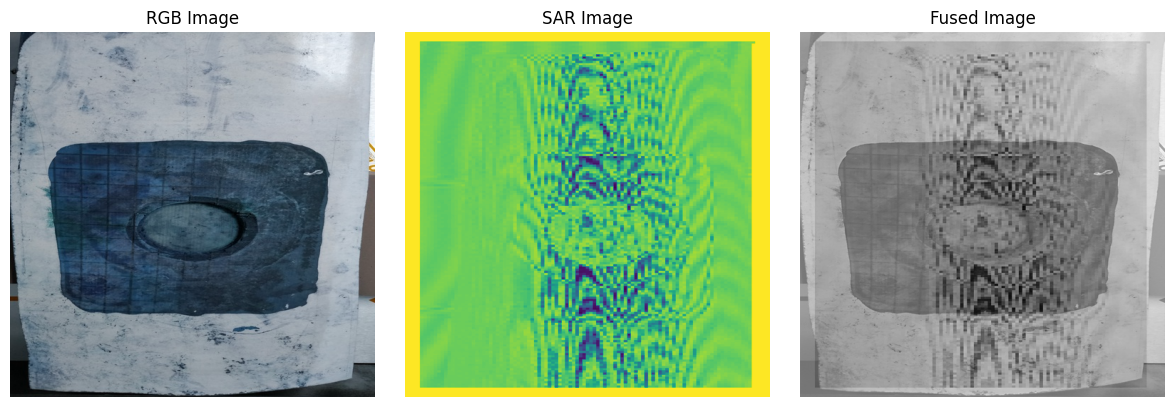

100%|██████████| 3/3 [00:19<00:00,  6.52s/it]

19.548362016677856


In [39]:
import time

t0 = time.time()


for name,i, j in tqdm(datas):

    RGB_img = cv2.imread(i)
    SAR_img = cv2.imread(j)
    
    print(type(RGB_img))
    
    #     # resize vis and ir to (600, 900)
    # RGB_img = cv2.resize(RGB_img, (244, 244))
    # SAR_img = cv2.resize(SAR_img, (244, 244))
    
        
    if len((SAR_img).shape) != 2:
        SAR_img = cv.cvtColor(SAR_img, cv.COLOR_BGR2GRAY)
    if len((RGB_img).shape) != 2:
        RGB_img = cv.cvtColor(RGB_img, cv.COLOR_BGR2GRAY)
        

    # with tf.device(device_name):
    pic = fuse(SAR_img, RGB_img)
    

    pict = pic * 255
    pict = pict.astype(np.uint8)
    plt.imsave(os.path.join('Output','Datak',name), pict, cmap='gray')
    
    # show_images(i, j, pic)
    

# code_block
t1 = time.time()

total = t1-t0
print(total)

# View Fused Image

In [40]:
dataDir = os.path.join('..','WindBlad_result','datak')
all_filesc = get_file_list(dataDir)
len(all_filesc)

15

In [41]:
filtered_files = [file for file in all_filesc if file.endswith(('.png', '.jpg','.nc')) and 'zoom' not in file and 'Zoom' not in file and 'fft' not in file and 'fft' not in file]
filtered_files

['..\\WindBlad_result\\datak\\Blad1A_orignal_img.png',
 '..\\WindBlad_result\\datak\\Blad1B_DataFIle.nc',
 '..\\WindBlad_result\\datak\\Blad1C.png',
 '..\\WindBlad_result\\datak\\Blad1E_fused.png',
 '..\\WindBlad_result\\datak\\Blad2A_Orignal.jpg',
 '..\\WindBlad_result\\datak\\Blad2B_DataFile.nc',
 '..\\WindBlad_result\\datak\\Blad2C.png',
 '..\\WindBlad_result\\datak\\Blad2E_fused.jpg',
 '..\\WindBlad_result\\datak\\Blad3A_Orignal.jpg',
 '..\\WindBlad_result\\datak\\Blad3B_DataFile.nc',
 '..\\WindBlad_result\\datak\\Blad3C.png',
 '..\\WindBlad_result\\datak\\Blad3E_fused.jpg']

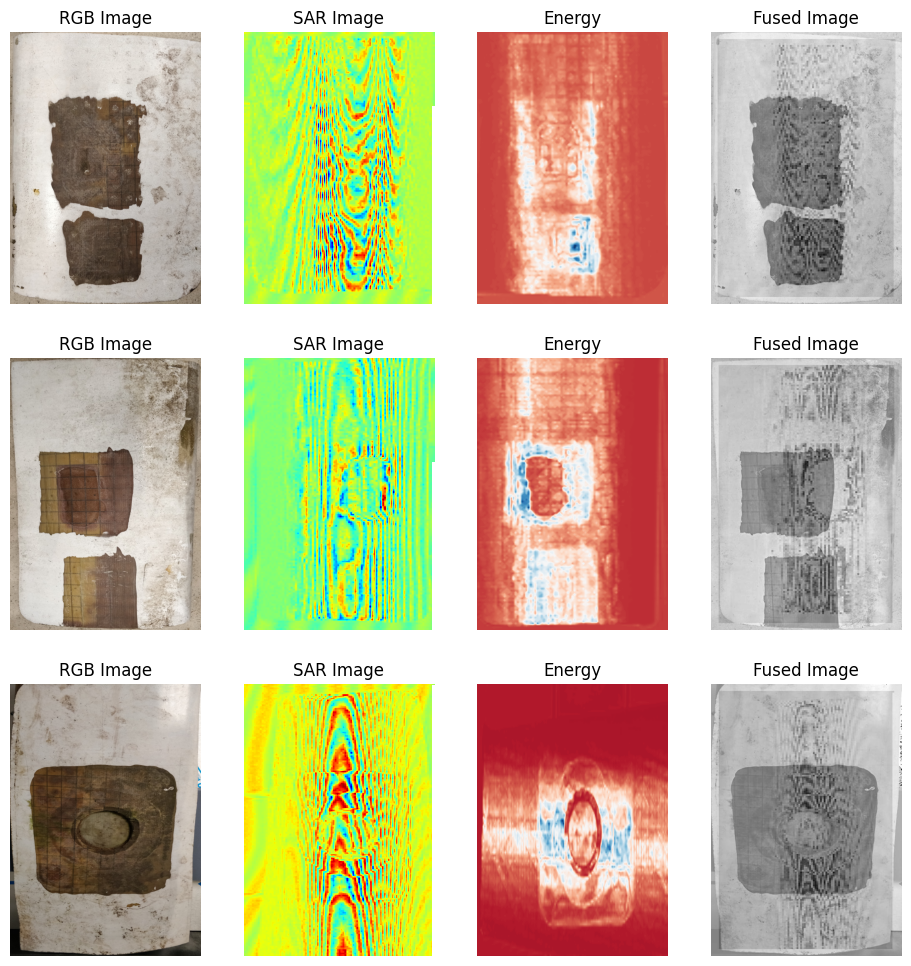

In [43]:
import matplotlib.pyplot as plt
import numpy as np
from netCDF4 import Dataset
from PIL import Image

# Set up the figure with the number of rows and columns
num_rows = len(filtered_files) // 4 
num_cols = 4
fig, axs = plt.subplots(num_rows, num_cols, figsize=(12, 4*num_rows))

# set maximum height and width among all images
max_height = 1000
max_width = 700
# Loop through each file and plot the RGB image, SAR image, and Energy image
for i, file in enumerate(filtered_files):    
    if 'orignal_img' in file or 'Orignal' in file:
        # RGB image
        img = Image.open(file)
        axs[i//num_cols, i%num_cols].imshow(np.asarray(img), aspect='equal', extent=[0,max_width,0,max_height])
        axs[i//num_cols, i%num_cols].set_title('RGB Image')
    elif file.endswith('.nc'):
        # SAR image
        ds = Dataset(file)
        sar_data = ds.variables['data']
        sar_data = np.flipud(sar_data)
        axs[i//num_cols, i%num_cols].imshow(sar_data[0], cmap='jet', aspect='equal', extent=[0,max_width,0,max_height])
        axs[i//num_cols, i%num_cols].set_title('SAR Image')
    elif 'fused' in file:
        # Fused image
        img = Image.open(file).resize((max_width, max_height))
        axs[i//num_cols, i%num_cols].imshow(np.asarray(img), cmap='gray', aspect='equal')
        axs[i//num_cols, i%num_cols].set_title('Fused Image')
    else:
        # Energy image
        img = Image.open(file).resize((max_width, max_height))
        axs[i//num_cols, i%num_cols].imshow(np.asarray(img), cmap='gray', aspect='equal')
        axs[i//num_cols, i%num_cols].set_title('Energy')

    axs[i//num_cols, i%num_cols].axis('off')

plt.subplots_adjust(wspace=0.02, hspace=0.2)
plt.savefig(os.path.join('Output','SAR_RGB.png'), bbox_inches='tight', pad_inches=0)
plt.show()
